# Genome Size Vs Complexity

### Imports

In [1]:
from logic_gates import run_evolution_strong_selection, run_random_walk, Circuit
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import concurrent.futures
from goals import or_funct

Setting up some utility functions and an object to track isomorphisms

In [2]:
def construct_genome(size: int) -> list:
    genome = []
    for i in range(int(size / 4)):
        genome += [0, 0, 1, 1, 2, 3, 4, 4]
    for i in range(max(0, size % 4)):
        genome += [5, 5]
    genome += [5]
    print(genome)
    return genome

class IsomorphismCounter:

    def __init__(self):
        self.counter = defaultdict(Counter)

    def add(self, network, size: int):
        for key in self.counter:
            if key.is_isomorphic(network, pruned=True):
                self.counter[key][size] += 1
                self.counter[key]["total"] += 1
                return key
        self.counter[network][size] += 1
        self.counter[network]["total"] += 1
        return network

    def get_networks(self):
        return self.counter.keys()

    def get_number_by_size(self, size: int):
        return {key: value[size] for key, value in self.counter.items()}

    def get_number_networks_total(self):
        return {key: value['total'] for key, value in self.counter.items()}


def run_in_parallel(function, axis, size, isomorphism_counter, *args):
    total_times = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_results = [executor.submit(function, *args) for i in range(500)]
        for f in tqdm(concurrent.futures.as_completed(future_results)):
            time, circuit, fitness = f.result()
            axis.plot(fitness)
            total_times.append(len(time))
            isomorphism_counter.add(circuit, size)
    return total_times

Goal Function

Now the actual simulation

[0, 0, 1, 1, 2, 3, 4, 4, 5]


0it [00:00, ?it/s]

4
Median:120.0
Mean:1325.176
STD:3106.6500171445127
[0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]


0it [00:00, ?it/s]

5
Median:126.0
Mean:928.398
STD:2158.6971820049243
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5]


0it [00:00, ?it/s]

8
Median:101.5
Mean:409.502
STD:1010.2732333364079
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]


0it [00:00, ?it/s]

9
Median:129.5
Mean:397.234
STD:1093.0480242166855
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5]


0it [00:00, ?it/s]

12
Median:105.0
Mean:350.824
STD:981.4744871997439
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]


0it [00:00, ?it/s]

13
Median:134.5
Mean:335.81
STD:743.767903246705
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5]


0it [00:00, ?it/s]

16
Median:134.0
Mean:324.272
STD:596.6038434472242
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]


0it [00:00, ?it/s]

17
Median:146.5
Mean:300.084
STD:456.4262579475462


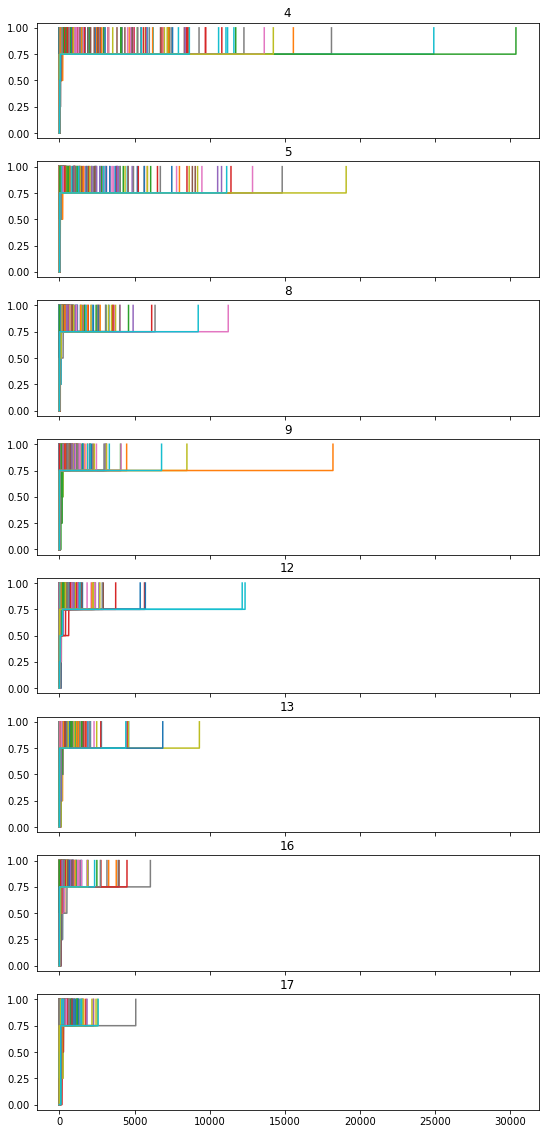

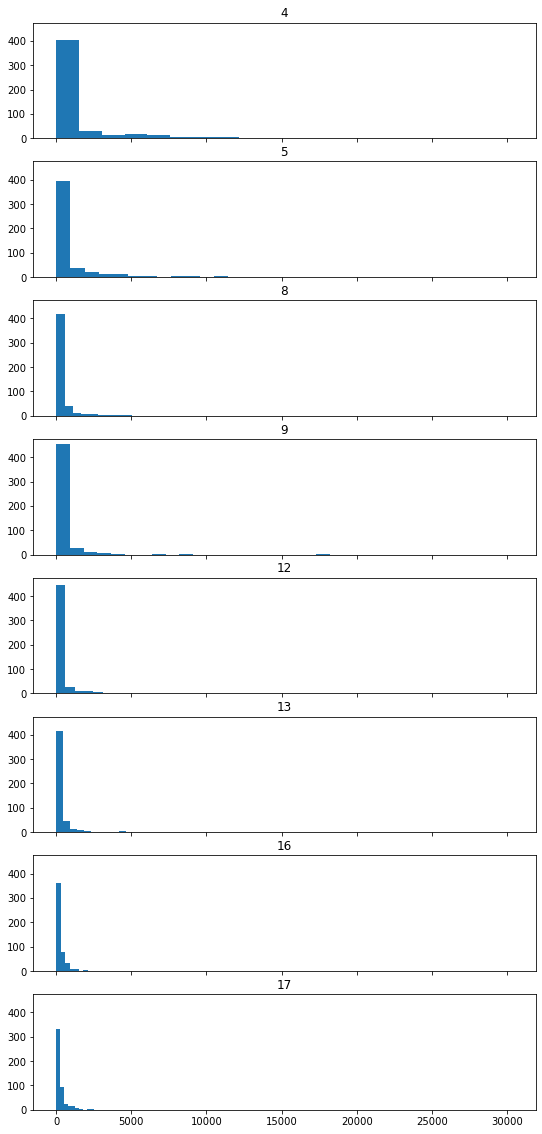

In [3]:
sizes = [4, 5, 8, 9, 12, 13, 16, 17]
fig_trajectory, ax_trajectories = plt.subplots(len(sizes), 1, sharex=True, sharey=True, figsize=(9, 20))
fig_histogram, ax_histograms = plt.subplots(len(sizes), 1, sharex=True, sharey=True, figsize=(9, 20))
means = []
medians = []
stds = []
isomorphism_counter = IsomorphismCounter()
num_trials = 100
for size, ax_trajectory, ax_histogram in zip(sizes, ax_trajectories, ax_histograms):
    ax_trajectory.set_title(size)
    ax_histogram.set_title(size)
    initial_circuit = Circuit(2, construct_genome(size))
    total_times = run_in_parallel(run_evolution_strong_selection, ax_trajectory, size, isomorphism_counter, or_funct, 1000, 0.1, initial_circuit, 10000)
    print(size)
    '''
    for i in tqdm(range(num_trials)):
        time, circuits, fitness = run_evolution_strong_selection(goal_function, 1000, 0.1, initial_circuit, 1000000)
        total_times.append(len(time))
        ax_trajectory.plot(fitness)
        isomorphism_counter.add(circuit, size)
    '''
    total_times_array = np.array(total_times)
    medians.append(np.median(total_times_array))
    print("Median:" + str(medians[-1]))
    means.append(total_times_array.mean())
    print("Mean:" + str(means[-1]))
    stds.append(total_times_array.std())
    print("STD:" + str(stds[-1]))
    ax_histogram.hist(total_times, 20)
fig_trajectory.savefig('trajectories.png', dpi=1200)
fig_histogram.savefig('histogram_fixations100.png')
plt.show()

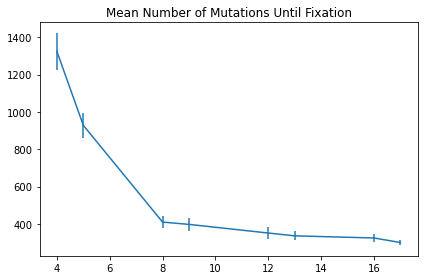

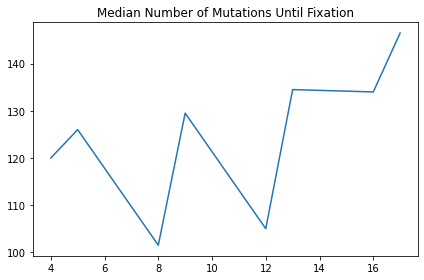

In [4]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.errorbar(x=sizes, y=means, yerr=np.array(stds)/np.sqrt(1000))
ax.set_title("Mean Number of Mutations Until Fixation")
plt.show()

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.errorbar(x=sizes, y=medians)
ax.set_title("Median Number of Mutations Until Fixation")
plt.show()

Maybe this can in some way be connected to the fact that adding more area for the binding site (more flexibility) leads to a greater chance of evolution. If I understood that correctly the other day.

Counter({'total': 1546, 4: 223, 8: 222, 16: 212, 12: 205, 17: 191, 13: 173, 9: 167, 5: 153})


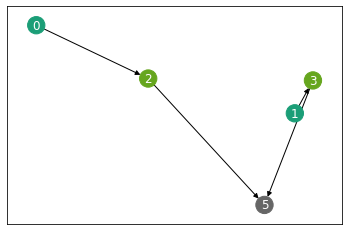

Counter({'total': 504, 4: 188, 5: 128, 8: 51, 9: 45, 13: 29, 12: 27, 16: 23, 17: 13})


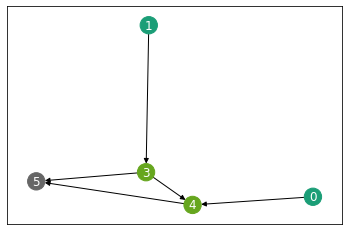

Counter({'total': 126, 5: 36, 4: 30, 8: 17, 9: 15, 17: 11, 16: 7, 12: 6, 13: 4})


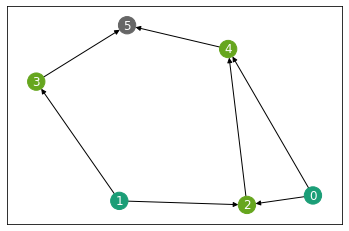

Counter({'total': 90, 5: 30, 4: 20, 8: 13, 9: 8, 13: 7, 17: 7, 16: 3, 12: 2})


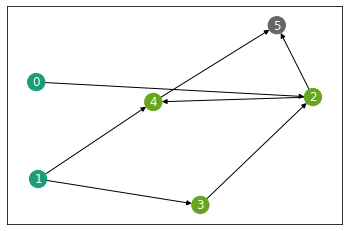

Counter({'total': 111, 5: 39, 4: 23, 9: 18, 12: 9, 13: 8, 8: 6, 16: 6, 17: 2})


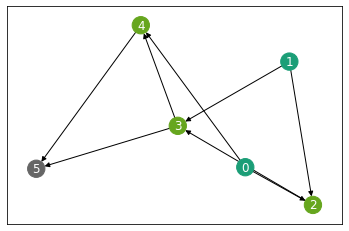

Counter({'total': 70, 9: 17, 5: 14, 4: 11, 8: 10, 12: 5, 17: 5, 13: 4, 16: 4})


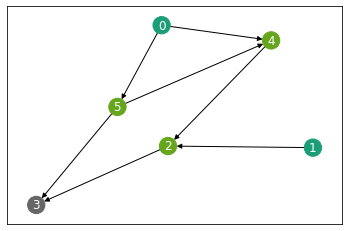

Counter({'total': 103, 12: 23, 17: 17, 8: 16, 13: 15, 9: 11, 16: 11, 4: 5, 5: 5})


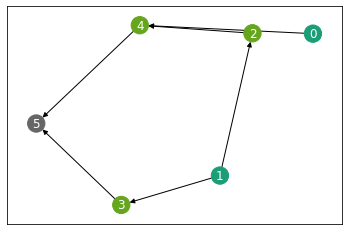

Counter({'total': 206, 5: 64, 9: 55, 13: 32, 17: 23, 8: 16, 12: 12, 16: 4})


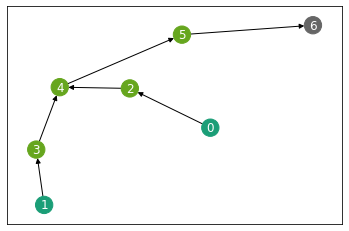

Counter({'total': 9, 9: 3, 13: 3, 5: 2, 12: 1})


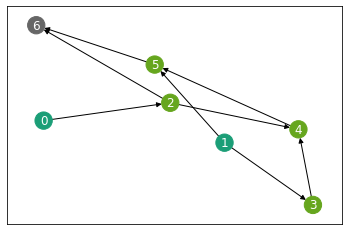

Counter({'total': 6, 5: 2, 9: 2, 12: 1, 17: 1})


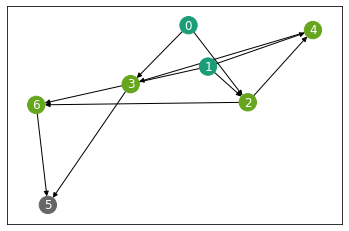

Counter({'total': 31, 13: 7, 12: 6, 16: 5, 17: 5, 8: 4, 5: 2, 9: 2})


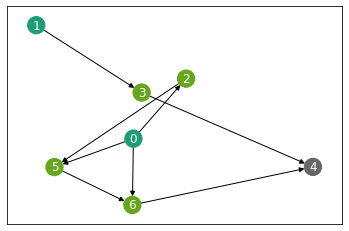

Counter({'total': 9, 5: 4, 8: 3, 9: 1, 12: 1})


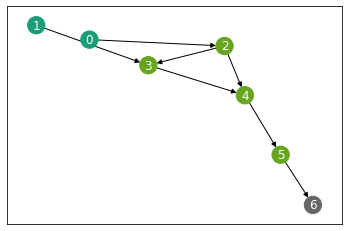

Counter({'total': 50, 13: 12, 8: 11, 16: 10, 9: 6, 12: 5, 17: 5, 5: 1})


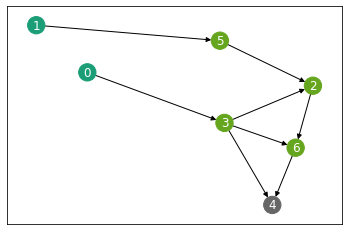

Counter({'total': 7, 9: 3, 12: 2, 5: 1, 8: 1})


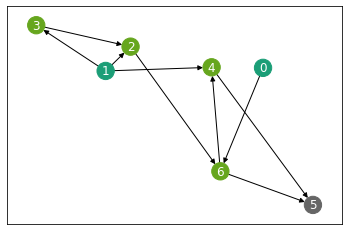

Counter({'total': 6, 9: 3, 5: 1, 8: 1, 12: 1})


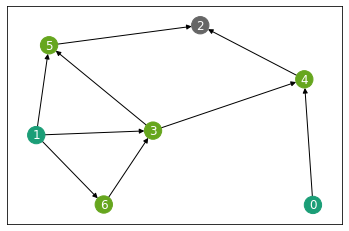

Counter({'total': 102, 17: 29, 13: 20, 16: 17, 12: 15, 8: 13, 9: 8})


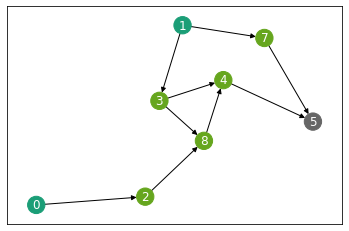

Counter({'total': 175, 16: 55, 17: 35, 13: 32, 12: 31, 9: 14, 8: 8})


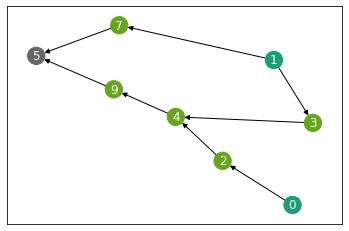

Counter({'total': 81, 8: 18, 16: 16, 12: 15, 9: 12, 13: 12, 17: 8})


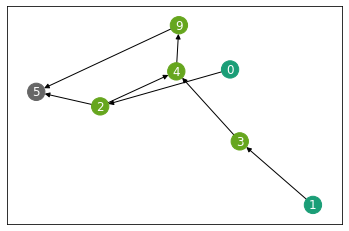

Counter({'total': 13, 8: 3, 9: 3, 12: 3, 16: 2, 13: 1, 17: 1})


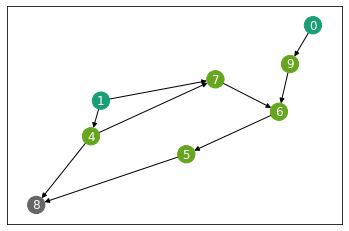

Counter({'total': 11, 9: 3, 13: 3, 16: 2, 8: 1, 12: 1, 17: 1})


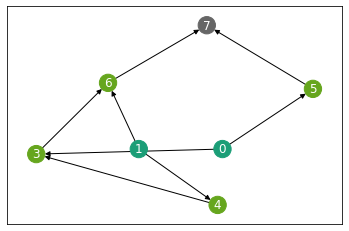

Counter({'total': 21, 8: 5, 9: 5, 12: 3, 16: 3, 17: 3, 13: 2})


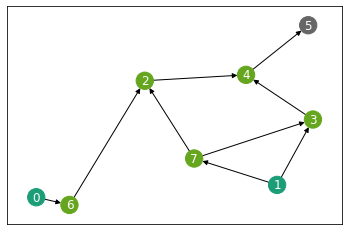

Counter({'total': 18, 9: 4, 12: 4, 8: 3, 16: 3, 17: 3, 13: 1})


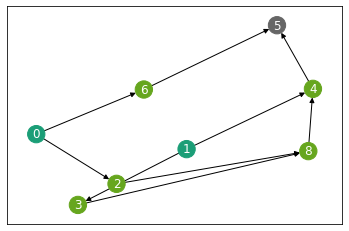

Counter({'total': 18, 12: 5, 9: 3, 13: 3, 17: 3, 8: 2, 16: 2})


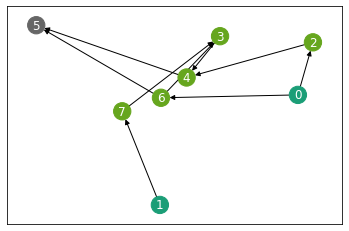

Counter({'total': 5, 8: 3, 9: 2})


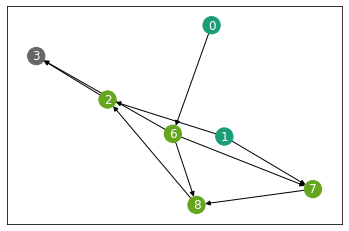

Counter({'total': 15, 12: 5, 17: 5, 8: 2, 9: 1, 13: 1, 16: 1})


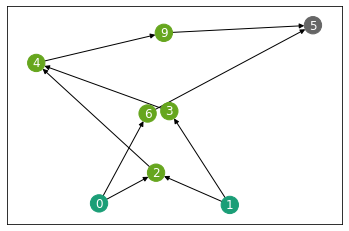

Counter({'total': 6, 8: 2, 13: 2, 9: 1, 17: 1})


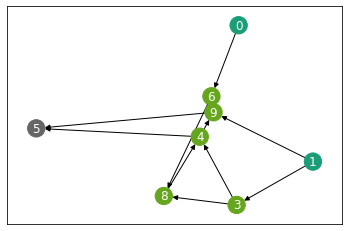

Counter({'total': 9, 16: 3, 13: 2, 8: 1, 9: 1, 12: 1, 17: 1})


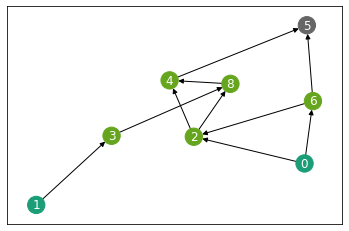

Counter({'total': 17, 13: 4, 16: 4, 17: 3, 8: 2, 9: 2, 12: 2})


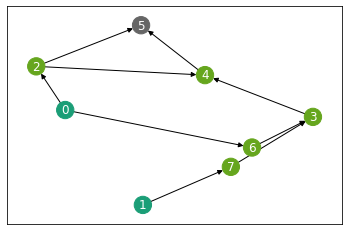

Counter({'total': 5, 9: 3, 8: 1, 12: 1})


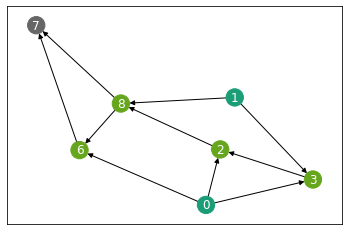

Counter({'total': 6, 17: 3, 8: 1, 12: 1, 13: 1})


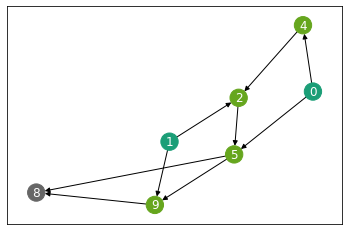

Counter({'total': 8, 8: 2, 13: 2, 16: 2, 12: 1, 17: 1})


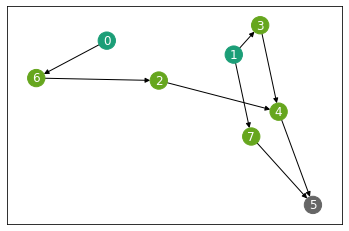

Counter({'total': 13, 13: 4, 17: 4, 9: 2, 12: 2, 16: 1})


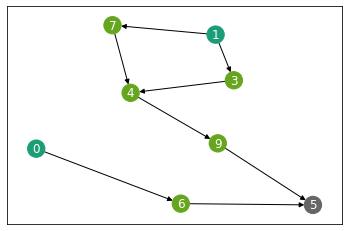

Counter({'total': 5, 9: 4, 17: 1})


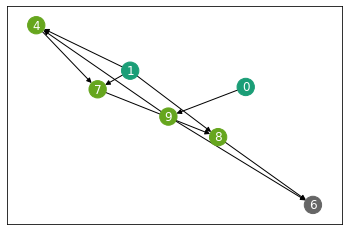

Counter({'total': 27, 12: 7, 16: 7, 13: 6, 17: 6, 9: 1})


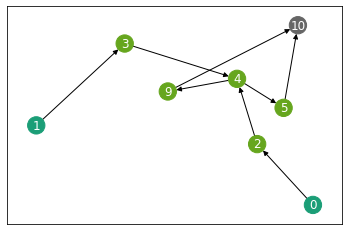

Counter({'total': 9, 16: 3, 17: 3, 12: 2, 13: 1})


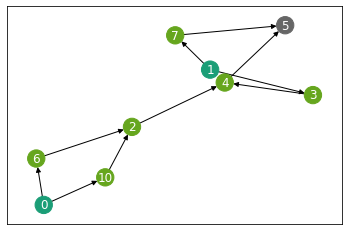

Counter({'total': 21, 16: 9, 12: 4, 13: 4, 17: 4})


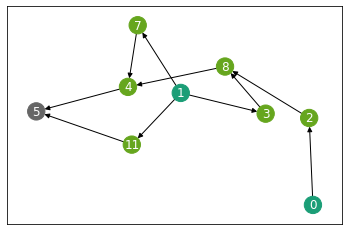

Counter({'total': 8, 17: 4, 16: 3, 12: 1})


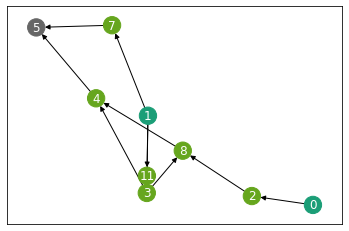

Counter({'total': 5, 17: 2, 12: 1, 13: 1, 16: 1})


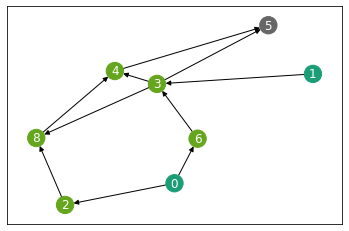

Counter({'total': 6, 13: 2, 16: 2, 12: 1, 17: 1})


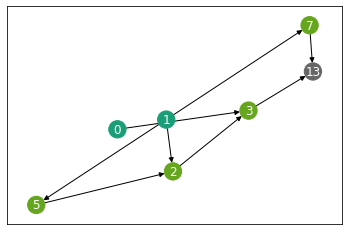

Counter({'total': 5, 16: 3, 12: 2})


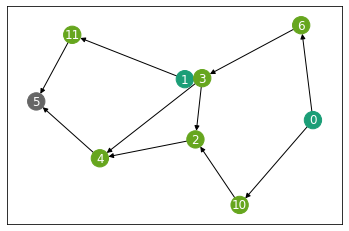

Counter({'total': 5, 16: 3, 12: 1, 17: 1})


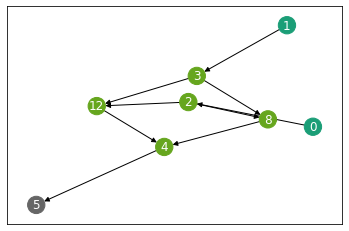

Counter({'total': 6, 13: 2, 17: 2, 12: 1, 16: 1})


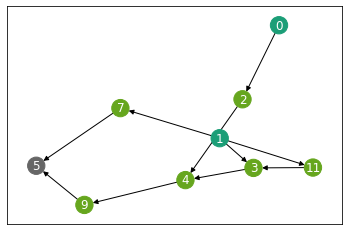

Counter({'total': 11, 16: 5, 13: 4, 17: 2})


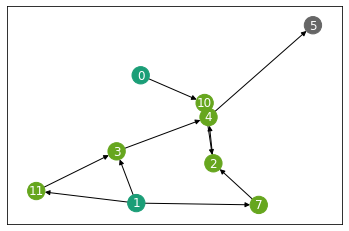

In [5]:
network_counter = isomorphism_counter.counter
for key, value in network_counter.items():
    if value['total'] > 4:
        print(value)
        key.plot_network(prune=True)
        plt.show()

In [6]:
list_unique_networks = list(isomorphism_counter.counter.keys())
list_unique_networks[:5]

[[0, 0, 1, 1, 2, 3, 2, 3, 5],
 [0, 0, 1, 1, 3, 0, 4, 3, 5],
 [0, 1, 1, 1, 2, 0, 3, 4, 5],
 [0, 3, 1, 1, 2, 1, 2, 4, 5],
 [1, 0, 1, 2, 0, 3, 4, 3, 5]]

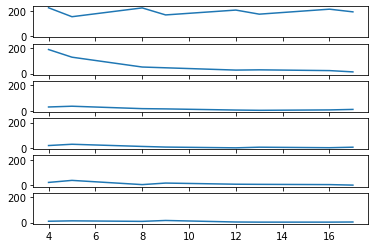

In [7]:
figs, axs = plt.subplots(6, 1, sharex=True, sharey=True)
for ax, network in zip(axs, list_unique_networks[:6]):
    ax.plot(sizes, [isomorphism_counter.get_number_by_size(size)[network] for size in sizes])

In [8]:
len(isomorphism_counter.counter)

457

Now to test how unique this behavior is via a random walk

[0, 0, 1, 1, 2, 3, 4, 4, 5]
4


  0%|          | 0/500 [00:00<?, ?it/s]

Median:83.0
Mean:128.252
STD:131.12498044232456
[0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]
5


  0%|          | 0/500 [00:00<?, ?it/s]

Median:65.5
Mean:108.684
STD:115.52513208821706
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5]
8


  0%|          | 0/500 [00:00<?, ?it/s]

Median:63.0
Mean:95.776
STD:100.42789365509961
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]
9


  0%|          | 0/500 [00:00<?, ?it/s]

Median:62.5
Mean:101.684
STD:105.07616353864468
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5]
12


  0%|          | 0/500 [00:00<?, ?it/s]

Median:65.5
Mean:100.042
STD:100.16296838652495
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]
13


  0%|          | 0/500 [00:00<?, ?it/s]

Median:66.5
Mean:99.3
STD:97.32546429378078
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5]
16


  0%|          | 0/500 [00:00<?, ?it/s]

Median:73.0
Mean:109.272
STD:114.05932673832508
[0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 5]
17


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

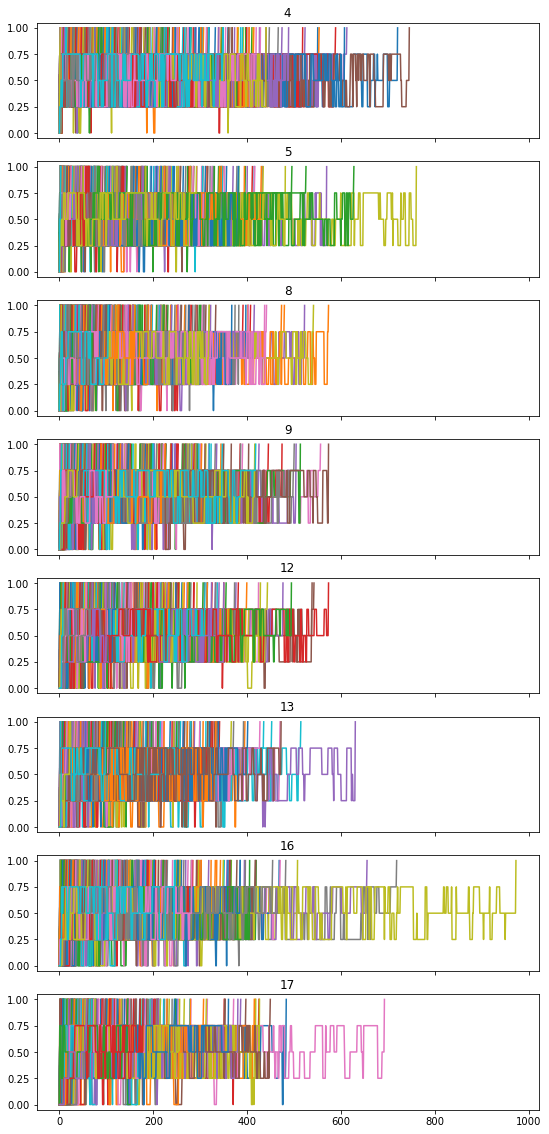

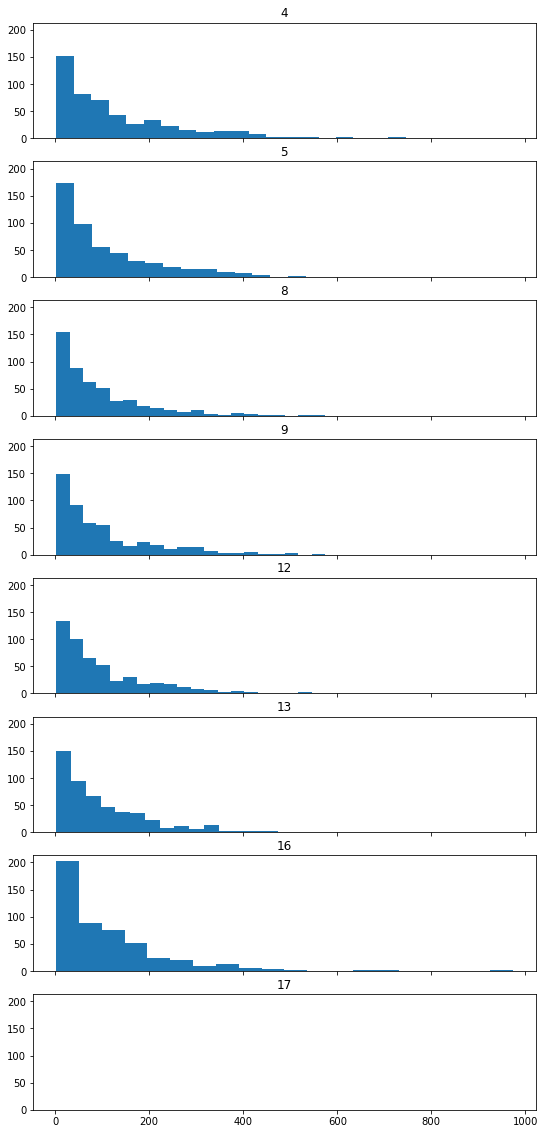

In [9]:
fig_trajectory, ax_trajectories = plt.subplots(len(sizes), 1, sharex=True, sharey=True, figsize=(9, 20))
fig_histogram, ax_histograms = plt.subplots(len(sizes), 1, sharex=True, sharey=True, figsize=(9, 20))
means = []
medians = []
stds = []
isomorphism_counter_random_walk = IsomorphismCounter()
num_trials = 500
for size, ax_trajectory, ax_histogram in zip(sizes, ax_trajectories, ax_histograms):
    ax_trajectory.set_title(size)
    ax_histogram.set_title(size)
    initial_circuit = Circuit(2, construct_genome(size))
    total_times = []
    print(size)
    for i in tqdm(range(num_trials)):
        time, circuits, fitness = run_random_walk(or_funct, 1000, 0.1, initial_circuit, 1000000)
        total_times.append(len(time))
        ax_trajectory.plot(fitness)
        isomorphism_counter_random_walk.add(circuits[-1], str(size) + " Random Walk")
    total_times_array = np.array(total_times)
    medians.append(np.median(total_times_array))
    print("Median:" + str(medians[-1]))
    means.append(total_times_array.mean())
    print("Mean:" + str(means[-1]))
    stds.append(total_times_array.std())
    print("STD:" + str(stds[-1]))
    ax_histogram.hist(total_times, 20)
fig_trajectory.savefig('trajectories.png', dpi=1200)
fig_histogram.savefig('histogram_fixations100.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.errorbar(x=sizes, y=means, yerr=np.array(stds)/np.sqrt(1000))
ax.set_title("Mean Number of Mutations Until Fixation")
plt.show()

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.errorbar(x=sizes, y=medians)
ax.set_title("Median Number of Mutations Until Fixation")
plt.show()

In [ ]:
network_counter_random_walk = isomorphism_counter_random_walk.counter
for key, value in network_counter_random_walk.items():
    if value['total'] > 4:
        print(value)
        key.plot_network(prune=True)
        plt.show()

In [ ]:
list_unique_networks_random_walk = list(isomorphism_counter_random_walk.counter.keys())
list_unique_networks_random_walk[:5]

In [ ]:
figs, axs = plt.subplots(6, 1, sharex=True, sharey=True)
for ax, network in zip(axs, list_unique_networks_random_walk):
    ax.plot(sizes, [isomorphism_counter_random_walk.get_number_by_size(str(size) + " Random Walk")[network] for size in sizes])